# Fast.ai Course Chapter 2 Bear Classifier Example

The goal of this notebook is to provide a tutorial of the bear classifier that is created in Chapter 2 of the Fast.ai book!

Chapter 2:
https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb

This doesn't follow every step one to one because I ran into issues myself working through it, which is what motivated me to make this tutorial. So please enjoy and I encourage you to read the book and take the course!
https://course.fast.ai/

In [1]:
# install the latest version of fastai
!pip install fastai -q --upgrade

In [2]:
# import packages and print fastai version
import fastai
print(fastai.__version__)
from fastai.vision.all import *
from pathlib import Path

2.7.13


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In the fastai book/course, the examples use either bing or duckduckgo APIs to run an image search and fetch data. I ran into a whole lot of trouble trying to follow along with the APIs that they used and was struggling to find alternatives to run an image web search in Python. Luckily I stumbled upon this dataset on Kaggle from someone else who had take this course and just uploaded the images from their own web search. So, we don't even have to run a web search to get the training data needed to follow along - we can just import their dataset!

Here is the original dataset:
https://www.kaggle.com/datasets/anirudhg15/bears-fastai-2021

Once you have uploaded the dataset to your notebook, you can define the path to the training data. You'll notice it contains 3 subdirectories, one for grizzly, black, and teddy bears.

This dataset appears to be from
2021 and I am currently going through the course in 2024. Although it's a couple of years old that should not really matter for our use case. Bears have not changed much since then!

In [3]:
# define the path where your training data is stored
path = Path('../input/bears-fastai-2021/bears')
path.ls()

(#3) [Path('../input/bears-fastai-2021/bears/grizzly'),Path('../input/bears-fastai-2021/bears/black'),Path('../input/bears-fastai-2021/bears/teddy')]

Next, we need to format our data into something that we can easily pass into a fastai model. One of the ways to do this with fastai is through the DataBlock data structure. Through the fastai API, we have access to this object. The DataBlock is a high level API that prepares our data for a DataLoader.

DataBlock: https://docs.fast.ai/data.block.html#datablock

To turn our training data into a DataBlock and then a DataLoader, we need to tell it a few things:
* What kind of data we are working with
* How to get the training data
* How to label these items
* How to create the validation set

We do all of that in the following block of code by creating the `DataBlock` object `bears`.

In [4]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Now, the book does a great job of explaining each  line of the above code in detail. So we won't do that here, but I will give a brief overview.

`blocks=(ImageBlock, CategoryBlock)` passes a tuple into the object which determines what we will want to make predictions from and our target. In this case, `ImageBlock` means we will pass in images to train the model - making this an image modality model. `CategoryBlock` just means we want the model to classify each image in a category (in our case bears).

`get_items=get_image_files` tells fastai how to retrieve the training data. `get_image_files` is a function defined by the fastai API that takes in a directory path and returns a list of all of the images in that path(recursively, by default).

`splitter=RandomSplitter(valid_pct=0.2, seed=42),` defines how the data should be split in terms of training and validation data. In this case, 20% of the data will be used for validation only while the model will be trained on the other 80%.

`get_y=parent_label,` tells fastai what function to call to create the labels in our dataset. `parent_label` is another fastai API function that gets the name of the folder a file is in. Since our bear images are stored in directories labelled by their bear type we can use this to derive their labels.

`item_tfms=Resize(128))` resizes all of the images so that they are the same size.

`bears` is now a `DataBlock` object which is like a template for creating a `DataLoaders` object. We still need to tell fastai the actual source of our data - in this case, the path where the images can be found.



In [5]:
# convert the DataBlock object to a DataLoaders object and
# pass in the path to the training data

dls = bears.dataloaders(path)

To learn more about the `DataLoaders` class, refer to the Fast.ai documentation:
https://docs.fast.ai/data.load.html

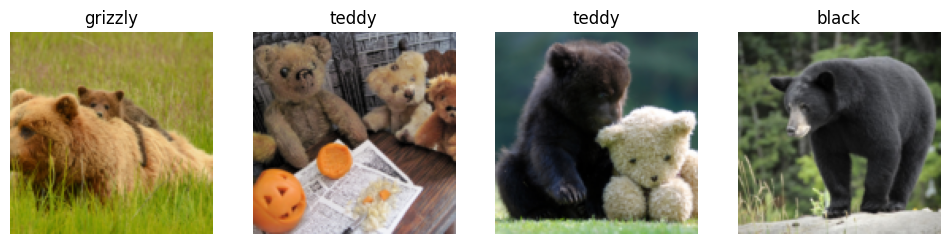

In [6]:
# view a few examples of the training data in the DataLoader
dls.valid.show_batch(max_n=4, nrows=1)

Below is an example of Data Augmentation, which refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data.

You'll remember when we constructed the `DataBlock` object we also resized the images. Well, resizing can lead to distorted images which can lead the model astray in training as it will then be training on images that can be unrealistic. To combat this, you can use data augmentation to train the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

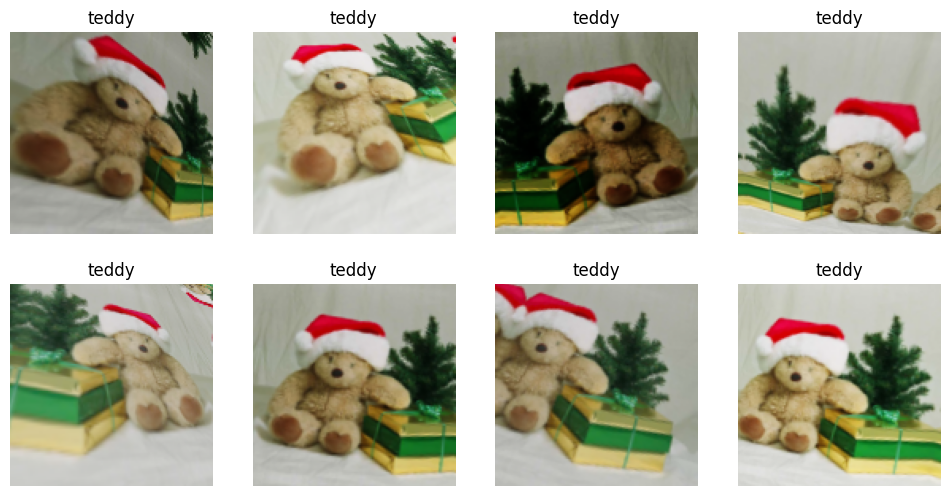

In [7]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now our data is prepped for training!

In [8]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

Create our `Learner` object and fine tune it. A learner groups together a model, DataLoaders, and a loss function to handle training.

Learner: https://docs.fast.ai/learner.html#learner

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.536028,0.347312,0.140351,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.248816,0.160973,0.070175,00:11
1,0.178291,0.046633,0.017544,00:12
2,0.136564,0.046316,0.017544,00:12
3,0.109395,0.037857,0.017544,00:12


Once the model is trained, we can view how it performed with a confusion matrix. This will show a graph displaying all of the predictions that were correct and incorrect.

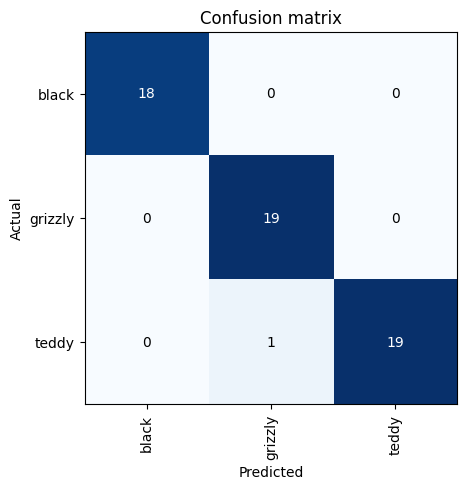

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

`plot_top_losses` will display x amount of predicions with the highest loss values. Interesting caveat, a prediction does not need to be incorrect to have a high loss function. A prediction that was correct, but with a low probability/confidence level will also have a high loss. A prediction that is incorrect with a high probability, meaning the model was confident in the prediction and was still wrong, will also have a high loss.

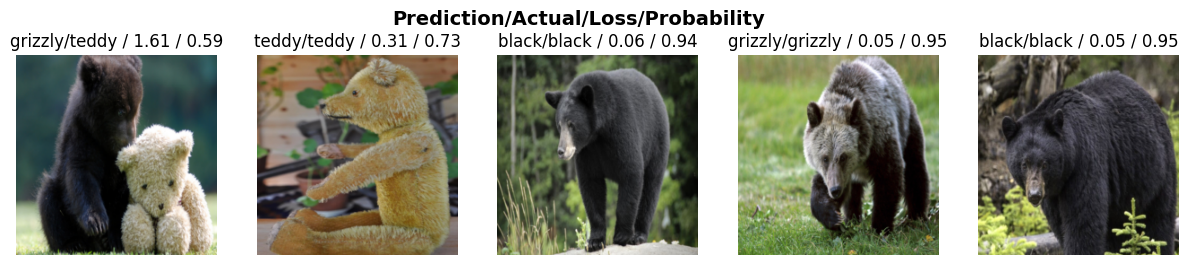

In [11]:
interp.plot_top_losses(5, nrows=1)

In the book, the argument is made that training the model first on the "uncleaned" data can help show you cases where your data may be inaccurate, which is an interesting point. If the labels on our data are incorrect, this is an easy way to spot that instead of manually sifting through the training data yourself.

fastai includes a cool GUI tool to use in notebooks that help you clean the data, but it has not worked for me so far. The following block of code should display images with dropdowns that allow you to re-label images or delete them completely from your dataset, but it just appears to be displaying the raw images by themselves...

In [12]:
cleaner = ImageClassifierCleaner(learn)
cleaner

NameError: name 'ImageClassifierCleaner' is not defined

In [ ]:
learn.lr_find()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(10, 1e-3)

In [ ]:
learn.dls = get_dls(16, 224)
learn.fine_tune(5, 1e-3)

In [ ]:
learn.show_results()

Utilize the `predict` API to conduct inference on our trained model

In [ ]:
learn.predict('../input/mybeardata/grizzly.jpeg')

The `export` API allows you to export our trained model and its weights in a `pkl` file. This allows you to take your trained model anywhere you please and utilize it for inference!

In [ ]:
learn.export(fname='model.pkl', pickle_module=pickle, pickle_protocol=2)

In [ ]:
reload_model=load_learner('model.pkl', cpu=True, pickle_module=pickle)
reload_model